In [1]:
### 测试字体是否可用

from matplotlib import font_manager
for f in font_manager.fontManager.ttflist:
    if 'PingFang' in f.name or 'Heiti' in f.name:
        print(f.name, f.fname)

Heiti TC /System/Library/Fonts/STHeiti Light.ttc
PingFang HK /System/Library/Fonts/PingFang.ttc
Heiti TC /System/Library/Fonts/STHeiti Medium.ttc
STHeiti /System/Library/AssetsV2/com_apple_MobileAsset_Font7/eb257c12d1a51c8c661b89f30eec56cacf9b8987.asset/AssetData/STHEITI.ttf
STHeiti /System/Library/AssetsV2/com_apple_MobileAsset_Font7/f0706a236683628e16427c6569e441423faaaa93.asset/AssetData/STXIHEI.ttf


In [2]:
### 验证热力图

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, f_oneway, tukey_hsd
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
#sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'sans-serif'          # 指定族
#plt.rcParams['font.sans-serif'] = ['SimHei']        # windows
plt.rcParams['font.sans-serif'] = ['PingFang HK']    # mac
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子确保结果可重现
np.random.seed(42)

In [4]:
# 1. 数据加载与预处理 - 修正版

def load_data_with_sheets():
    """加载所有数据文件，处理多张数据表的情况"""
    data_files = {
        '描述性统计': '../pre_data/1.描述性统计.xlsx',
        '微观叙事-词法': '../pre_data/2-1微观叙事-词法.xlsx',
        '微观叙事-句法': '../pre_data/2-2微观叙事-句法.xlsx',
        '宏观叙事-语篇连贯性': '../pre_data/3-1宏观叙事-语篇连贯性.xlsx',
        '宏观叙事-情境模型': '../pre_data/3-2宏观叙事-情境模型.xlsx',
        '宏观叙事-段落长度': '../pre_data/3-3宏观叙事-段落长度.xlsx'
    }
    
    data_dict = {}
    
    for name, file_path in data_files.items():
        try:
            # 读取Excel文件的所有工作表
            excel_file = pd.ExcelFile(file_path)
            sheet_names = excel_file.sheet_names
            
            print(f"\n✓ 成功加载: {name}")
            print(f"  文件路径: {file_path}")
            print(f"  工作表: {sheet_names}")
            
            # 检查是否包含年级相关的工作表
            grade_sheets = []
            for sheet in sheet_names:
                if any(keyword in sheet for keyword in ['高一', '高二', '高三', 'grade1', 'grade2', 'grade3']):
                    grade_sheets.append(sheet)
            
            if grade_sheets:
                print(f"  发现年级工作表: {grade_sheets}")
                
                # 合并所有年级数据，添加年级标识
                combined_data = []
                grade_mapping = {
                    '高一': 1, '高二': 2, '高三': 3,
                    'grade1': 1, 'grade2': 2, 'grade3': 3
                }
                
                for sheet in grade_sheets:
                    df_sheet = pd.read_excel(file_path, sheet_name=sheet)
                    
                    # 确定年级值
                    grade_value = None
                    for key, value in grade_mapping.items():
                        if key in sheet:
                            grade_value = value
                            break
                    
                    if grade_value:
                        # 添加年级列
                        df_sheet['年级'] = grade_value
                        combined_data.append(df_sheet)
                        print(f"    工作表 '{sheet}' -> 年级 {grade_value}, 数据形状: {df_sheet.shape}")
                
                if combined_data:
                    # 合并所有年级数据
                    final_df = pd.concat(combined_data, ignore_index=True)
                    data_dict[name] = final_df
                    print(f"  合并后总数据形状: {final_df.shape}")
                else:
                    print(f"  ⚠️ 警告: 无法处理年级数据")
                    # 如果无法处理，读取第一个工作表
                    df = pd.read_excel(file_path, sheet_name=sheet_names[0])
                    data_dict[name] = df
                    print(f"  使用第一个工作表，数据形状: {df.shape}")
            else:
                print(f"  ⚠️ 警告: 未发现年级工作表，使用第一个工作表")
                df = pd.read_excel(file_path, sheet_name=sheet_names[0])
                data_dict[name] = df
                print(f"  数据形状: {df.shape}")
                
        except Exception as e:
            print(f"✗ 加载失败: {name} - 错误: {e}")
    
    return data_dict

# 加载数据
data_dict = load_data_with_sheets()

# 显示每个数据文件的基本信息
for name, df in data_dict.items():
    print(f"\n{name} 数据预览:")
    print(f"列名: {list(df.columns)}")
    print(f"数据形状: {df.shape}")
    
    # 检查年级列
    if '年级' in df.columns:
        print(f"年级分布: {df['年级'].value_counts().sort_index()}")
    
    print(f"前5行数据:")
    print(df.head())
    print("-" * 50)


✓ 成功加载: 描述性统计
  文件路径: ../pre_data/1.描述性统计.xlsx
  工作表: ['高一', '高二', '高三']
  发现年级工作表: ['高一', '高二', '高三']
    工作表 '高一' -> 年级 1, 数据形状: (100, 4)
    工作表 '高二' -> 年级 2, 数据形状: (100, 4)
    工作表 '高三' -> 年级 3, 数据形状: (100, 4)
  合并后总数据形状: (300, 4)

✓ 成功加载: 微观叙事-词法
  文件路径: ../pre_data/2-1微观叙事-词法.xlsx
  工作表: ['高一', '高二', '高三']
  发现年级工作表: ['高一', '高二', '高三']
    工作表 '高一' -> 年级 1, 数据形状: (100, 10)
    工作表 '高二' -> 年级 2, 数据形状: (100, 10)
    工作表 '高三' -> 年级 3, 数据形状: (100, 10)
  合并后总数据形状: (300, 10)

✓ 成功加载: 微观叙事-句法
  文件路径: ../pre_data/2-2微观叙事-句法.xlsx
  工作表: ['高一', '高二', '高三']
  发现年级工作表: ['高一', '高二', '高三']
    工作表 '高一' -> 年级 1, 数据形状: (100, 13)
    工作表 '高二' -> 年级 2, 数据形状: (100, 13)
    工作表 '高三' -> 年级 3, 数据形状: (100, 13)
  合并后总数据形状: (300, 13)

✓ 成功加载: 宏观叙事-语篇连贯性
  文件路径: ../pre_data/3-1宏观叙事-语篇连贯性.xlsx
  工作表: ['高一', '高二', '高三']
  发现年级工作表: ['高一', '高二', '高三']
    工作表 '高一' -> 年级 1, 数据形状: (100, 10)
    工作表 '高二' -> 年级 2, 数据形状: (100, 10)
    工作表 '高三' -> 年级 3, 数据形状: (100, 10)
  合并后总数据形状: (300, 10)

✓ 成功加载: 宏观叙事-情境模型
  文件

In [5]:
data = pd.read_csv('../pre_data/全部特征合并表.csv')
data.head()

,文本编号,单词数量-DESWC-03,句子数量-DESSC-02,年级,多样性-LDVOCDa（51）,密度-WRDFRQC（94）,复杂度-K1,复杂度-K2,复杂度-K3,复杂度-K4,...,整体连贯-CRFAOa（32）,整体连贯-CRFSOa（33）,整体连贯-LSASSp（42）,整体连贯-LSAPP1（44）,整体连贯-LSAGN（46）,因果衔接-SMCAUSr-64,意图衔接-SMINTEr-65,时体衔接-SMTEMP-68,段落平均长度-DESPL-04,段落平均长度标准差-DESPLd-05
0,1.txt,152,14,1,59.249001,2.396,92.903,3.226,3.226,0.645,...,0.776,0.129,0.189,0.488,0.306,0.200,0.300,0.923,7.0,0.000
1,1.txt,151,12,2,66.051002,2.302,88.000,6.667,2.667,1.333,...,0.615,0.246,0.198,0.601,0.321,0.714,0.556,0.909,6.0,0.000
2,1.txt,199,10,3,100.049004,2.030,81.000,9.000,6.000,2.500,...,0.911,0.222,0.146,0.561,0.261,0.167,0.500,1.000,5.0,0.000
3,10.txt,193,17,1,89.566002,2.277,88.144,6.186,2.062,3.093,...,0.548,0.113,0.091,0.688,0.272,0.333,0.222,0.750,8.5,0.707
4,10.txt,182,14,2,81.035004,2.095,83.607,6.011,6.011,2.186,...,0.353,0.118,0.136,0.232,0.252,0.000,0.556,1.000,7.0,4.243


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   文本编号                 300 non-null    object 
 1   单词数量-DESWC-03        300 non-null    int64  
 2   句子数量-DESSC-02        300 non-null    int64  
 3   年级                   300 non-null    int64  
 4   多样性-LDVOCDa（51）      300 non-null    float64
 5   密度-WRDFRQC（94）       300 non-null    float64
 6   复杂度-K1               300 non-null    float64
 7   复杂度-K2               300 non-null    float64
 8   复杂度-K3               300 non-null    float64
 9   复杂度-K4               300 non-null    float64
 10  复杂度-K5               300 non-null    float64
 11  复杂度-K6+              300 non-null    float64
 12  短语长度-SYNLE（69）       300 non-null    float64
 13  短语长度-SYNNP（70）       300 non-null    float64
 14  短语密度-DRNP（76）        300 non-null    float64
 15  短语密度-DRVP（77）        300 non-null    flo

In [11]:
from untils import create_complexity_pca,create_complexity_composite_mean

k_cols = ['复杂度-K1', '复杂度-K2', '复杂度-K3', '复杂度-K4', '复杂度-K5', '复杂度-K6+']
tmp_df = create_complexity_pca(data,k_cols,n_components=1,target_col_name='复杂度-K')
tmp_df.head()

,文本编号,单词数量-DESWC-03,句子数量-DESSC-02,年级,多样性-LDVOCDa（51）,密度-WRDFRQC（94）,短语长度-SYNLE（69）,短语长度-SYNNP（70）,短语密度-DRNP（76）,短语密度-DRVP（77）,...,整体连贯-CRFSOa（33）,整体连贯-LSASSp（42）,整体连贯-LSAPP1（44）,整体连贯-LSAGN（46）,因果衔接-SMCAUSr-64,意图衔接-SMINTEr-65,时体衔接-SMTEMP-68,段落平均长度-DESPL-04,段落平均长度标准差-DESPLd-05,复杂度-K
0,1.txt,152,14,1,59.249001,2.396,2.071,0.488,309.210999,296.053009,...,0.129,0.189,0.488,0.306,0.200,0.300,0.923,7.0,0.000,8.529398
1,1.txt,151,12,2,66.051002,2.302,2.917,0.733,324.502991,211.921005,...,0.246,0.198,0.601,0.321,0.714,0.556,0.909,6.0,0.000,3.091166
2,1.txt,199,10,3,100.049004,2.030,6.900,0.836,326.632996,211.054993,...,0.222,0.146,0.561,0.261,0.167,0.500,1.000,5.0,0.000,-4.999401
3,10.txt,193,17,1,89.566002,2.277,2.529,0.673,316.062012,238.341995,...,0.113,0.091,0.688,0.272,0.333,0.222,0.750,8.5,0.707,3.402520
4,10.txt,182,14,2,81.035004,2.095,3.643,0.644,390.109985,252.746994,...,0.118,0.136,0.232,0.252,0.000,0.556,1.000,7.0,4.243,-1.782805


In [12]:
tmp_df = create_complexity_composite_mean(tmp_df,
                                          ['短语长度-SYNLE（69）', '短语长度-SYNNP（70）'],
                                          target_col_name='短语长度-PhraseLength')
tmp_df = create_complexity_composite_mean(tmp_df,
                                          ['短语密度-DRNP（76）', '短语密度-DRVP（77）',
                                           '短语密度-DRPP（79）'],
                                          target_col_name='短语密度-PhraseDensity')

tmp_df = create_complexity_composite_mean(tmp_df,
                                          ['句子结构-DRPVAL（80）', '句子结构-DRNEG（81）',
                                           '句子结构-DRINF（83）'],
                                          target_col_name='句子结构-SentenceStructure')

tmp_df = create_complexity_composite_mean(tmp_df,
                                          ['句法相似-SYNSTRUTa（74）', '句法相似-SYNSTRUTt（75）'],
                                          target_col_name='句法相似-SYNSTRUT')
tmp_df.head()

,文本编号,单词数量-DESWC-03,句子数量-DESSC-02,年级,多样性-LDVOCDa（51）,密度-WRDFRQC（94）,句子长度-DESSL（06）,局部连贯-CRFAO1（29）,局部连贯-CRFSO1（30）,局部连贯-LSASS1(40),...,因果衔接-SMCAUSr-64,意图衔接-SMINTEr-65,时体衔接-SMTEMP-68,段落平均长度-DESPL-04,段落平均长度标准差-DESPLd-05,复杂度-K,短语长度-PhraseLength,短语密度-PhraseDensity,句子结构-SentenceStructure,句法相似-SYNSTRUT
0,1.txt,152,14,1,59.249001,2.396,11.000,0.615,0.154,0.179,...,0.200,0.300,0.923,7.0,0.000,8.529398,1.2795,221.491669,15.351000,0.1705
1,1.txt,151,12,2,66.051002,2.302,12.583,0.545,0.091,0.143,...,0.714,0.556,0.909,6.0,0.000,3.091166,1.8250,211.920664,8.830333,0.1415
2,1.txt,199,10,3,100.049004,2.030,20.000,0.889,0.111,0.091,...,0.167,0.500,1.000,5.0,0.000,-4.999401,3.8680,209.379997,13.400667,0.0665
3,10.txt,193,17,1,89.566002,2.277,11.412,0.438,0.063,0.043,...,0.333,0.222,0.750,8.5,0.707,3.402520,1.6010,215.889336,8.635667,0.1615
4,10.txt,182,14,2,81.035004,2.095,13.000,0.462,0.231,0.128,...,0.000,0.556,1.000,7.0,4.243,-1.782805,2.1435,249.084328,12.820666,0.1415


In [13]:
#'宏观叙事-语篇连贯性', '宏观叙事-情境模型', '宏观叙事-段落长度']
tmp_df = create_complexity_composite_mean(tmp_df,
                                          ['局部连贯-CRFAO1（29）', '局部连贯-CRFSO1（30）',
                                           '局部连贯-LSASS1(40)'],
                                          target_col_name='局部连贯-LocalCoherence')

from untils import create_complexity_pca

tmp_df = create_complexity_pca(tmp_df,
                               ['整体连贯-CRFAOa（32）','整体连贯-CRFSOa（33）','整体连贯-LSASSp（42）',
                                '整体连贯-LSAPP1（44）','整体连贯-LSAGN（46）'],
                               target_col_name='整体连贯-GlobalCoherence')

tmp_df.head()

,文本编号,单词数量-DESWC-03,句子数量-DESSC-02,年级,多样性-LDVOCDa（51）,密度-WRDFRQC（94）,句子长度-DESSL（06）,因果衔接-SMCAUSr-64,意图衔接-SMINTEr-65,时体衔接-SMTEMP-68,段落平均长度-DESPL-04,段落平均长度标准差-DESPLd-05,复杂度-K,短语长度-PhraseLength,短语密度-PhraseDensity,句子结构-SentenceStructure,句法相似-SYNSTRUT,局部连贯-LocalCoherence,整体连贯-GlobalCoherence
0,1.txt,152,14,1,59.249001,2.396,11.000,0.200,0.300,0.923,7.0,0.000,8.529398,1.2795,221.491669,15.351000,0.1705,0.316000,0.199559
1,1.txt,151,12,2,66.051002,2.302,12.583,0.714,0.556,0.909,6.0,0.000,3.091166,1.8250,211.920664,8.830333,0.1415,0.259667,0.120865
2,1.txt,199,10,3,100.049004,2.030,20.000,0.167,0.500,1.000,5.0,0.000,-4.999401,3.8680,209.379997,13.400667,0.0665,0.363667,0.358569
3,10.txt,193,17,1,89.566002,2.277,11.412,0.333,0.222,0.750,8.5,0.707,3.402520,1.6010,215.889336,8.635667,0.1615,0.181333,0.018060
4,10.txt,182,14,2,81.035004,2.095,13.000,0.000,0.556,1.000,7.0,4.243,-1.782805,2.1435,249.084328,12.820666,0.1415,0.273667,-0.257099


In [15]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   文本编号                    300 non-null    object 
 1   单词数量-DESWC-03           300 non-null    int64  
 2   句子数量-DESSC-02           300 non-null    int64  
 3   年级                      300 non-null    int64  
 4   多样性-LDVOCDa（51）         300 non-null    float64
 5   密度-WRDFRQC（94）          300 non-null    float64
 6   句子长度-DESSL（06）          300 non-null    float64
 7   因果衔接-SMCAUSr-64         300 non-null    float64
 8   意图衔接-SMINTEr-65         300 non-null    float64
 9   时体衔接-SMTEMP-68          300 non-null    float64
 10  段落平均长度-DESPL-04         300 non-null    float64
 11  段落平均长度标准差-DESPLd-05     300 non-null    float64
 12  复杂度-K                   300 non-null    float64
 13  短语长度-PhraseLength       300 non-null    float64
 14  短语密度-PhraseDensity      300 non-null    fl

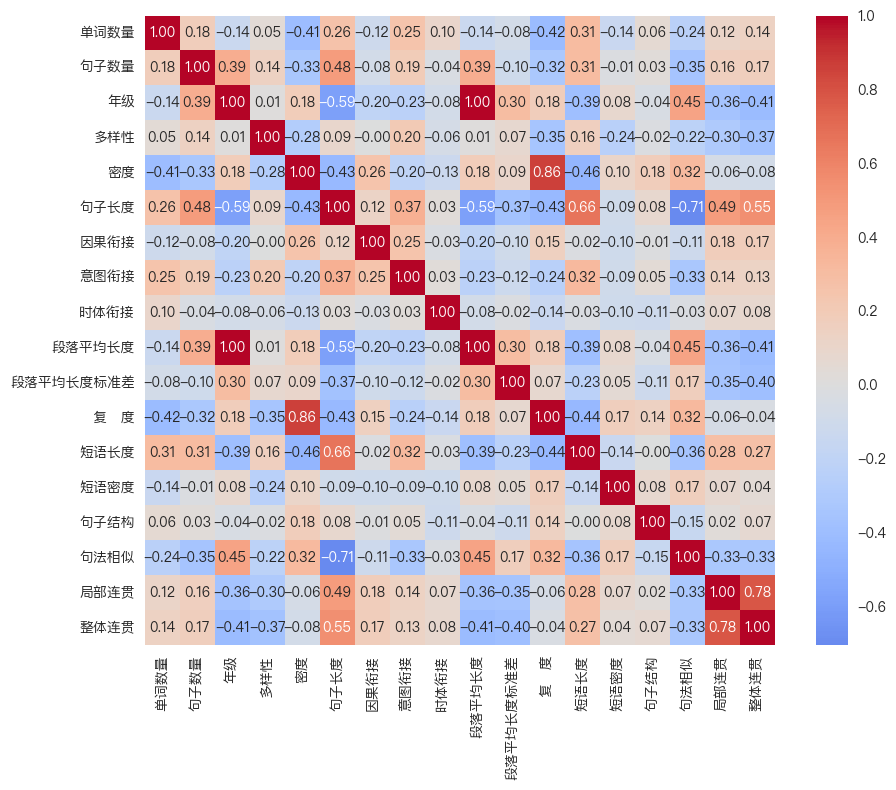

In [17]:
def create_feature_correlation_heatmap(df, feature_cols):
    """
    输入一个DataFrame和要分析的特征列，输出这些特征之间的相关性热力图。
    展示特征名时，仅取'-'分割后的第一个元素。
    参数:
        df: 包含特征的数据框
        feature_cols: 需要分析的特征列名列表
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 只保留指定的特征列，并去除缺失值
    data = df[feature_cols].dropna()
    #将年级特征列提到第一列的位置
    data = data[['年级'] + [col for col in data.columns if col != '年级']]
    #data.info()
    # 计算相关性矩阵
    corr_matrix = data.corr()

    # 处理特征名，只取'-'分割后的第一个元素
    simple_names = [col.split('-')[0] for col in feature_cols]
    # 设置行列名
    corr_matrix.index = simple_names
    corr_matrix.columns = simple_names

    # 绘制热力图
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
    #plt.title('特征间相关性热力图')
    plt.tight_layout()
    plt.show()

#tmp_df = pd.read_csv('./tmp/全部特征合并表_融合.csv')
cols = tmp_df.columns.to_list()
cols.remove('文本编号')
create_feature_correlation_heatmap(tmp_df, cols)